# Causal Discovery

In this section, we discuss what might happen if we do not know the causal graph a priori. Such cases can arise when there is a lack of domain knowledge about the causal mechanisms of a particular topic.

For this demonstration, we will focus on the [PC algorithm](https://www.frontiersin.org/articles/10.3389/fgene.2019.00524/full). This algorithm attempts to learn causal structure in scenarios where we do not have unmeasured confounding. To be precise, we learn a completed partial DAG, which can be thought of as the coarser class of DAGs that represents the limit of what can be learned from observational data (since certain causal structures like the chain and fork are observationally indistinguishable).

To demonstrate some of the ideas in this section, we will make use of the [causal-learn package](https://github.com/cmu-phil/causal-learn), which is one of several causal discovery packages available today. We use it because it is a native Python package, which is being ported by authors of the [TETRAD project](https://github.com/cmu-phil/tetrad), a long-established causal discovery package in Java with a nice GUI.

Other packages include:
* [CDT](https://github.com/FenTechSolutions/CausalDiscoveryToolbox): Python implementation of many TETRAD algorithms
* [gCastle](https://github.com/huawei-noah/trustworthyAI): Offers gradient-accelerated implementations of PC-style algorithms
* [causal-cmd](https://github.com/bd2kccd/causal-cmd): A powerful command-line interface to many algorithms in TETRAD that are useful in practice


In [1]:
import pandas as pd
import io
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from causallearn.utils.cit import kci, gsq, chisq, fisherz
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from IPython.display import Image, display

def view_pydot(pdot):
    """
    https://stackoverflow.com/questions/4596962/display-graph-without-saving-using-pydot
    """
    plt = Image(pdot.create_png())
    display(plt)
    
    
def view_graph(graph, names):
    pyd = GraphUtils.to_pydot(graph.G, labels=names)

    view_pydot(pyd)

/home/intuitivecomputing/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We consider a [dataset](https://archive.ics.uci.edu/ml/datasets/student+performance) in which we have data about student performance in secondary education of two Portuguese schools. The data has attributes about student grades, socioeconomic factors, and school-related features. 

The outcome of interest are the grades at the end of 1st, 2nd, and 3rd grade (G1, G2, G3).

A causal question that we might ask is, "What are the causal factors that impact student grades?"

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/cmu-phil/example-causal-datasets/main/real/student-performance/data/student-performance.data.mixed.maximum.3.txt", sep='\t')

In [3]:
names = list(df.columns)

In [4]:
name_map = dict(zip(range(len(names)), names))

In [5]:
categorical_columns = ["school", "sex", "address", "famsize", "Pstatus", 
                       "Mjob", "Fjob", "reason", "guardian", "schoolsup", "famsup", "paid", "activities", 
                      "nursery", "higher", "internet", "romantic"]

In [6]:
for var in categorical_columns:
    df[var] = df[var].astype("category").cat.codes

In [7]:
df = df.astype(float)

In [8]:
data = df.values

In [9]:
cg = pc(data=data, 
        indep_test=fisherz,
        alpha=.1, 
        show_progress=True)



Depth=6, working on node 32: 100%|█████████████| 33/33 [00:00<00:00, 572.50it/s]


In [10]:
view_graph(cg, names)

We supply the raw data (in the form of a data matrix) and allow the PC algorithm to attempt to determine causal structure through conditional independence tests without any other background information or knowledge.

This output is a CPDAG, in which the undirected edges represent ambiguity over which direction the edge points. 

Overall, the results are quite revealing despite the lack of information given to the algorithm. For example, the algorithm determined correctly that the outcomes G1, G2, G3 would be causally influenced by all the other variables (although the ordering between these variables is not quite right). Other reasonable causal relationships include the choice of "school" (one of two high schools), which is influenced by the "traveltime" (a measure of the distance to the school) and the "address" (urban or rural).

In other instances, the algorithm draws causal relationships that are unlikely or impossible. For instance, "Fjob" (Father's job) influencing "Fedu" (father's education) seems to be the wrong way round. Certain other variables determined early on in life such as "age" or "sex" are more plausibly causes of other variables, not their effects.

To improve the performance of the algorithm, we might consider grouping variables into _tiers_, which represent groups of variables which are contemporaneous and that influence only subsequent tiers. Supplying this knowledge to the algorithm will rule out nonsensical causal structures and improve its performance.

In [11]:
tier_0 = ["sex", "age", "address", "famsize", "Pstatus", "Medu", "Fedu"]
tier_2 = ["G1", "G2", "G3"]
tier_1 = list(set(names) - set(tier_0) - set(tier_2))
tier_map = dict(zip(tier_0 + tier_1 + tier_2, [0] * len(tier_0) + [1] * len(tier_1) + [2] * len(tier_2)))
bg = BackgroundKnowledge()
for node in cg.G.nodes:
    val = cg.G.node_map[node] 
    name = name_map[val]
    bg.add_node_to_tier(node, tier_map[name])

In [12]:
cg2 = pc(data=data, 
        indep_test=fisherz,
        alpha=.1, 
        show_progress=True, background_knowledge=bg)

Depth=6, working on node 32: 100%|█████████████| 33/33 [00:00<00:00, 566.30it/s]


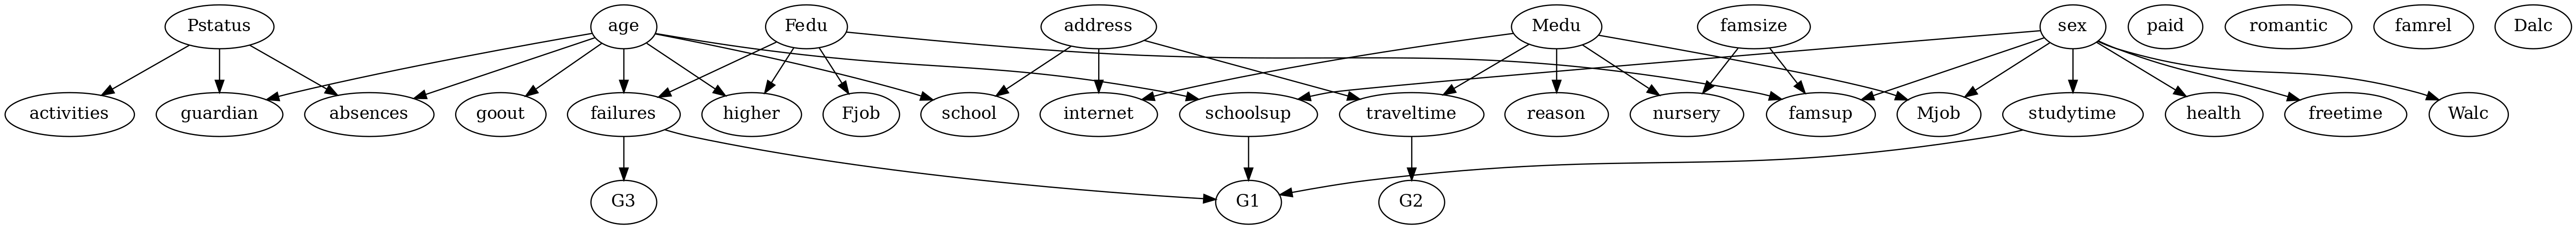

In [13]:
view_graph(cg2, names)

The tiers enforce a causal structure such that variables from one tier can only affect subsequent tiers (but not within a tier). In this model, 1st year grades are influenced by "studytime" (weekly study time), "failures" (number of past class failures), and "schoolsup" (extra education support). "Fedu" (father's education) affects "Fjob" (father's job) and likewise for the mother with "Medu" and "Mjob".

If we believe this graph, then it indicates that, for instance, providing school supplemental education ("schoolsup") might positively influence 1st year grades ("G1"). However, the choice of school does not affect the student's grade.

Why might we not believe this graph? First, we might have reason to believe that there are unmeasured confounding variables. Many socioeconomic variables such as family income are not measured in this study, which may influence a student's grade. Second, the analysis is dependent on the particular settings (the choice of conditional independence test and the hyperparameter alpha). Varying these settings is necessary to understand the impact of modeling choices on the analysis.